In [131]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
    
import matplotlib.pyplot as plt
%matplotlib inline

In [132]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [133]:
def plot_data(A, b, test = False):
    positive_indices = np.where(b == 1)[0]
    negative_indices = np.where(b == 0)[0]
    
    plt.scatter(A.iloc[positive_indices, 0], A.iloc[positive_indices, 1], marker='x', c= 'yellow' if test else 'green')
    plt.scatter(A.iloc[negative_indices, 0], A.iloc[negative_indices, 1], marker='+', c= 'blue' if test else 'red')

In [187]:
def decision_boundary(X, y, theta, mean=1, std=1):
    grid_x = np.array([X.iloc[0, :].min()-5,  X.iloc[1, :].max()+5])

    #y_grid = (-1 / (theta[1])) * (theta[0] * x_grid)
    #plot_y = (-1 / theta[2]) * (theta[1] * plot_x + theta[0]);
    y_grid = (-std / (theta[2])) * (theta[1] * ((grid_x - mean) / std) + theta[0]) + mean
    plt.plot(x_grid, y_grid)

In [135]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class CustomLogisticRegressionEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, normalize=True):
        self.is_normalize = normalize

    def fit(self, X, y, alpha, num_iters):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y

        if self.is_normalize == True:
            X_norm, self.mean, self.std = self.normalize(self.X_)
            X = self.prepare_X(X_norm)
        else:
            X = self.prepare_X(self.X_)

        theta = np.zeros(X.shape[1])
        self.coef_, self.Js = self.gradient_descent(X, self.y_, theta, alpha, num_iters, False)

    def predict(self, X):
        # Check is fit had been called
        # check_is_fitted(self)

        # Input validation
        X = check_array(X)

        if self.is_normalize:
            X_norm = (X - self.mean) / self.std
            X_proc = self.prepare_X(X_norm)
            y_pred = self.hypothesis(X_proc, self.coef_)
        else:
            X_proc = self.prepare_X(X)
            y_pred = self.hypothesis(X_proc, self.coef_)
        y = [1 if (x >= 0.5) else 0 for x in y_pred]
        return y

    def get_cost_history(self):
        #check_is_fitted(self)
        return self.Js

    def normalize(self, X):
        mean = np.mean(X)
        std = np.std(X)
        X_new = (X - mean) / std
        return X_new, mean, std

    def prepare_X(self, X):
        m = X.shape[0]
        ones = np.ones((m, 1))
        X_new = np.array(X[:])
        X_new = np.column_stack((ones, X_new))
        return X_new

    def derivative(self, X, y, theta):
        m = X.shape[0]

        h0 = self.hypothesis(X, theta)
        d_theta = (1 / m) * X.T.dot((h0 - y));
        return d_theta

    def cost_function(self, X, y, theta):
        m = X.shape[0]
        if m == 0:
            return None

        # J = 1 / (2 * m) * sum((self.hypothesis(X, theta) - y) ** 2)
        h0 = self.hypothesis(X, theta)
        J = (1 / m) * ( (-y.T).dot(np.log(h0)) - (1 - y).T.dot(np.log(1 - h0)) )
        return J

    def sigmoid(self, z):
        """
        Sigmoid function
        :param z: array or matrix of values
        :return: sigmoid values
        """
        return 1 / (1 + np.exp(-z))

    def hypothesis(self, X, theta):
        h_thetha = np.dot(X, theta)
        return self.sigmoid(h_thetha)

    def prepare_X(self, X):
        m = X.shape[0]
        ones = np.ones((m, 1))
        X_new = np.array(X[:])
        X_new = np.column_stack((ones, X_new))
        return X_new
    
    def gradient_descent(self, X, y, theta, alpha, num_iters, print_J=True):
        m = X.shape[0]
        J_history = []
        J = self.cost_function(X, y, theta)
        if print_J == True:
            print(J)
        J_history.append(J)
        for i in range(num_iters):
            delta = self.derivative(X, y, theta)
            #print(delta)
            theta = theta - alpha * delta
            J = self.cost_function(X, y, theta)

            if print_J == True:
                print(J)
            J_history.append(J)
        return theta, J_history

In [136]:
filename = "sats.csv"

x_features = ["exam1", "exam2"]
y_feature = ["submitted"]

data_features = x_features + y_feature

df = pd.read_csv(filename, sep=',')

#df = df.sample(100)
df = df[data_features]

X, y = df[x_features], df[y_feature]
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(100, 2), y=(100, 1)


In [137]:
df.head()

,exam1,exam2,submitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exam1      100 non-null    float64
 1   exam2      100 non-null    float64
 2   submitted  100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(80, 2), y=(80, 1)
Test set: X=(20, 2), y=(20, 1)


[1.68922895 4.24281421 3.86807981]


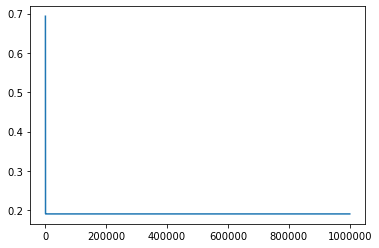

In [163]:
lg = CustomLogisticRegressionEstimator(normalize=True)
# Without normalization
# 1 000 000 
# 0.0001

lg.fit(X_train, y_train, 1, 1000000)

print(lg.coef_)
plot_J(lg.get_cost_history())


In [189]:
#plot_x = np.array([X.iloc[0, :].min()-5,  X.iloc[1, :].max()+5]);
#plot_y = (-1 / theta[2]) * (theta[1] * plot_x + theta[0]);

#plt.plot(plot_x, plot_y, '-o')

theta = lg.coef_
plot_data(X_train, y_train)

decision_boundary(X_train, y_train, lg.coef_, lg.mean, lg.std)
# grid_x = np.array([X_train.iloc[:, 0].min()-5,  X_train.iloc[:, 1].max()+5])
# y_grid = (-1 / (theta[2])) * (theta[1] * grid_x + theta[0])


#good
#y_grid = (-lg.std / (theta[2])) * (theta[1] * ((grid_x - lg.mean) / lg.std) + theta[0]) + lg.mean
#y_grid = (y_grid - lg.mean) / lg.std

print(grid_x)
plt.plot(grid_x, y_grid)


y_pred = lg.predict(X_test)
plot_data(X_test, np.array(y_pred), test=True)


plt.show()
print(theta)





ValueError: x and y must have same first dimension, but have shapes (100,) and (2,)

In [142]:
print(lg.predict(np.array([[10, 10], [20, 20], [30, 30], [40, 40], [50, 50], [60, 60], [70, 70], [80, 80], [90, 90], [100, 100]])))
print(lg.predict(np.array([[0, 10], [30, 70], [10, 90], [80, 70], [20, 50], [50, 20], [70, 20], [90, 32]])))

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 0, 1, 0, 1, 1, 1]
